In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import pickle

In [2]:
def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):

        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

#### Drfiter Data

In [3]:
drifter_path = '/srv/scratch/z5297792/IN2023/2023_drifters.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
tim_drif, ID_drif = drifter_dataset['time'][:].data, drifter_dataset['ID'][:].data
dt_strings = [b''.join(row).decode('utf-8') for row in tim_drif]
tim_drif = [datetime.fromisoformat(s) for s in dt_strings]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters

,ID,Lon,Lat,u,v,Time
0,1,155.071686,-37.423271,0.336407,-0.524240,2023-10-23 16:00:00
1,1,155.085403,-37.440243,0.342941,-0.514329,2023-10-23 17:00:00
2,1,155.099655,-37.456573,0.356158,-0.494175,2023-10-23 18:00:00
3,1,155.114456,-37.472240,0.367879,-0.471484,2023-10-23 19:00:00
4,1,155.129669,-37.487103,0.357340,-0.426944,2023-10-23 20:00:00
...,...,...,...,...,...,...
32704,19,157.954788,-33.808270,0.788511,-0.257061,2023-12-30 18:00:00
32705,19,157.985443,-33.815174,0.778468,-0.190267,2023-12-30 19:00:00
32706,19,158.015457,-33.820591,0.769020,-0.143037,2023-12-30 20:00:00
32707,19,158.045380,-33.824436,0.766826,-0.095277,2023-12-30 21:00:00


#### Ship Data

In [4]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=z_sadcp)
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=z_sadcp)
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

depth = 37
df_sadcp = pd.DataFrame({'Lon': lon_sadcp, 'Lat': lat_sadcp, 'u': u_sadcp.loc[depth], 'v': v_sadcp.loc[depth], 'Time': tim_sadcp})
# df_sadcp.set_index('Time', inplace=True)
df_sadcp

,Lon,Lat,u,v,Time
0,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...
2169,152.133657,-33.499170,-0.193570,-1.186649,2023-11-01 03:40:29.666685
2170,152.162703,-33.499744,-0.265587,-1.283703,2023-11-01 03:55:29.333340
2171,152.191377,-33.499695,-0.273816,-1.294686,2023-11-01 04:10:29.666658
2172,152.220223,-33.499658,-0.283102,-1.272112,2023-11-01 04:25:29.333353


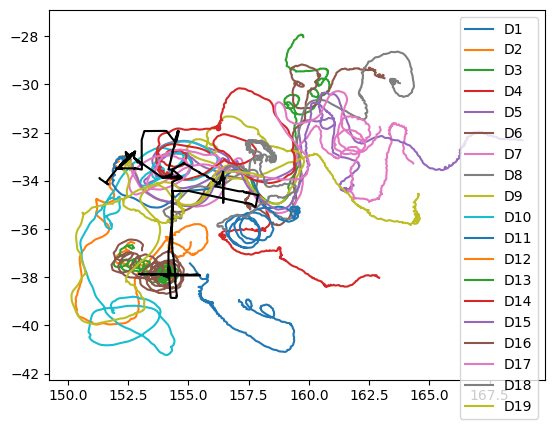

In [5]:
for ID in df_drifters['ID'].unique():

    df_drif = df_drifters[df_drifters['ID']==ID]
    plt.plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')

plt.axis('equal')
plt.legend()

plt.plot(df_sadcp['Lon'], df_sadcp['Lat'], c='k')


In [6]:
df_obs_data = pd.concat([df_drifters, df_sadcp], ignore_index=True, sort=False)
df_obs_data = df_obs_data.sort_values(by='Time').reset_index(drop=True)
# df_obs_data = df_obs_data[df_obs_data['Time'] <= pd.Timestamp('2023-12-10 06:00:00')]
df_obs_data

,ID,Lon,Lat,u,v,Time
0,NaN,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,NaN,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,NaN,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,NaN,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,NaN,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...,...
34878,8.0,163.780426,-29.946438,0.223790,-0.060704,2023-12-30 23:00:00.000000
34879,4.0,162.917786,-38.022373,0.095789,0.021097,2023-12-30 23:00:00.000000
34880,6.0,163.140686,-29.742563,0.579057,-0.107962,2023-12-30 23:00:00.000000
34881,7.0,164.334869,-33.275684,0.171763,-0.353148,2023-12-30 23:00:00.000000


#### Satellite Data

In [7]:
ssh_path = '/srv/scratch/z5297792/IN2023/IMOS_aggregation.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')
lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
# u_ssh, v_ssh = np.where(u_ssh > -4, u_ssh, np.nan), np.where(v_ssh > -4, u_ssh, np.nan)
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

tim_ssh = tim_ssh[tim_ssh <= pd.Timestamp('2023-12-05 06:00:00')] # '2023-12-11 14:00:00'


(-38.4, -37.4)

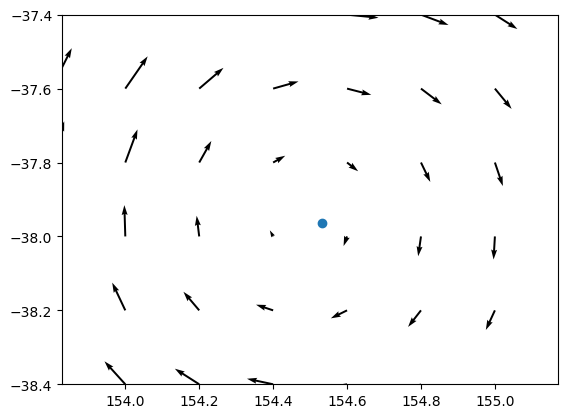

In [8]:
lon_min_CE, lon_max_CE = 154, 155
lat_min_CE, lat_max_CE = -38.4, -37.4

t = 0
ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
plt.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=.004, scale=10)

mask = (lon_ssh >= lon_min_CE) & (lon_ssh <= lon_max_CE) & (lat_ssh >= lat_min_CE) & (lat_ssh <= lat_max_CE)
xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
x0, y0, Q, w = espra(xi, yi, ui, vi)
plt.scatter(x0, y0)

plt.axis('equal')
plt.xlim(lon_min_CE, lon_max_CE)
plt.ylim(lat_min_CE, lat_max_CE)




In [9]:
lon_min_CE, lon_max_CE = 154, 155
lat_min_CE, lat_max_CE = -38.4, -37.4

dic_obs = {}

x0, y0 = np.mean([lon_min_CE, lon_max_CE]), np.mean([lat_min_CE, lat_max_CE])
x0_obs, y0_obs, Q_obs, w_obs = np.nan, np.nan, np.nan, np.nan
df_trace = pd.DataFrame(columns=['x0_SAT', 'y0_SAT', 'Q_SAT', 'w_SAT','x0_OBS', 'y0_OBS', 'Q_OBS', 'w_OBS', 'Time'])
for t, time in enumerate(tim_ssh):
 
    if (x0 < lon_ssh.min()) or (x0 > lon_ssh.max()) or (y0 < lat_ssh.min()) or (y0 > lat_ssh.max()):
        break
    
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    if t == 0:
        mask = (lon_ssh >= lon_min_CE) & (lon_ssh <= lon_max_CE) & (lat_ssh >= lat_min_CE) & (lat_ssh <= lat_max_CE)
    else:
        mask = np.hypot(x0 - lon_ssh, y0 - lat_ssh) <= .2
    
    xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
    
    x0_old, y0_old = x0, y0
    x0, y0, Q, w = espra(xi, yi, ui, vi)

    if np.hypot(x0 - x0_old, y0 - y0_old) < 1:
        
        t1 = time - pd.Timedelta(days=.5)
        t2 = time + pd.Timedelta(days=.5)

        R = np.hypot(x0 - df_obs_data['Lon'], y0 - df_obs_data['Lat']) < 1
        local_obs_data = df_obs_data[(R) & (df_obs_data['Time'] >= t1) & (df_obs_data['Time'] <= t2)]
        if not local_obs_data.empty:
            xi, yi, ui, vi = local_obs_data['Lon'], local_obs_data['Lat'], local_obs_data['u'], local_obs_data['v'] 
            x0_obs, y0_obs, Q_obs, w_obs = espra(xi, yi, ui, vi)
            
            if np.hypot(x0 - x0_obs, y0 - y0_obs) >= 1:
                x0_obs, y0_obs, Q_obs, w_obs = np.nan, np.nan, np.nan, np.nan
                
        else:
            x0_obs, y0_obs, Q_obs, w_obs = np.nan, np.nan, np.nan, np.nan

        if not np.isnan(x0_obs):
            dic_obs[time] = {'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi}
        
        df_trace.loc[len(df_trace)] = {'x0_SAT': x0, 'y0_SAT': y0, 'Q_SAT': Q, 'w_SAT': w, 
                                               'x0_OBS': x0_obs, 'y0_OBS': y0_obs, 'Q_OBS': Q_obs, 'w_OBS': w_obs,
                                               'Time': time}


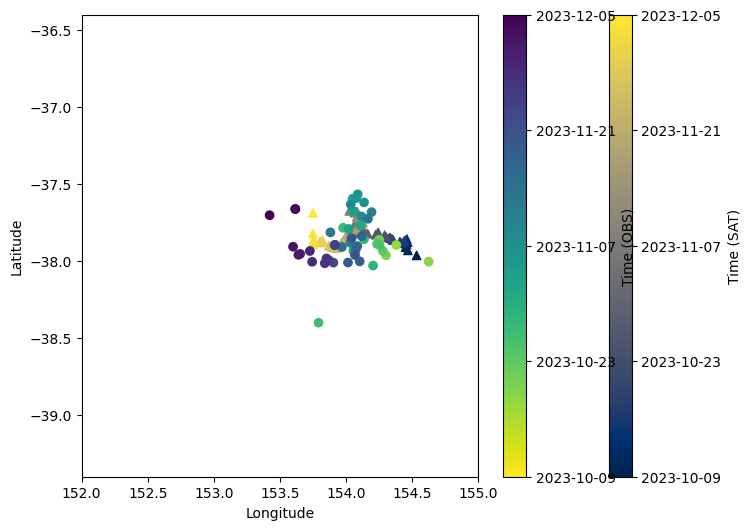

In [10]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(8, 6))

ts_sat = np.array([t.timestamp() for t in df_trace['Time']])
ts_obs = np.array([t.timestamp() for t in df_trace['Time']])

norm = mcolors.Normalize(vmin=ts_sat.min(), vmax=ts_sat.max())

sc1 = ax.scatter(df_trace['x0_SAT'], df_trace['y0_SAT'], c=ts_sat, cmap=plt.cm.cividis, norm=norm, marker='^')
cbar1 = plt.colorbar(sc1, ax=ax, label="Time (SAT)")

sc2 = ax.scatter(df_trace['x0_OBS'], df_trace['y0_OBS'], c=ts_obs, cmap=plt.cm.viridis_r, norm=norm)
cbar2 = plt.colorbar(sc2, ax=ax, label="Time (OBS)")

tick_locs = np.linspace(ts_sat.min(), ts_sat.max(), num=5)
for cbar in [cbar1, cbar2]:
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([pd.to_datetime(t, unit='s').strftime('%Y-%m-%d') for t in tick_locs])

ax.set_xlim(lon_min_CE - 2, lon_max_CE)
ax.set_ylim(lat_min_CE - 1, lat_max_CE + 1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


In [11]:
df_trace

,x0_SAT,y0_SAT,Q_SAT,w_SAT,x0_OBS,y0_OBS,Q_OBS,w_OBS,Time
0,154.532419,-37.962941,"[[-0.5416575626577694, 0.029117066031543553], ...",-2.191472,NaN,NaN,NaN,NaN,2023-10-09 18:00:00
1,154.466340,-37.930386,"[[-0.6980780329632007, 0.05264319772900968], [...",-2.868692,NaN,NaN,NaN,NaN,2023-10-10 18:00:00
2,154.448446,-37.909527,"[[-0.806986895158862, 0.09231684644359126], [0...",-3.113594,NaN,NaN,NaN,NaN,2023-10-11 18:00:00
3,154.455736,-37.891271,"[[-0.7593039067853671, 0.08077726314573079], [...",-2.972068,NaN,NaN,NaN,NaN,2023-10-12 18:00:00
4,154.464998,-37.877260,"[[-0.761974154137779, 0.055981465302784174], [...",-2.911793,NaN,NaN,NaN,NaN,2023-10-13 18:00:00
5,154.457752,-37.856179,"[[-0.732410701350523, 0.0408178711918852], [0....",-2.794681,NaN,NaN,NaN,NaN,2023-10-14 18:00:00
6,154.423492,-37.883187,"[[-1.009067345231118, 0.035287321164384905], [...",-3.692668,NaN,NaN,NaN,NaN,2023-10-15 18:00:00
7,154.406291,-37.873552,"[[-0.9571884503658676, 0.023080170646005704], ...",-3.567547,NaN,NaN,NaN,NaN,2023-10-16 18:00:00
8,154.440164,-37.867523,"[[0.999981156961859, -0.01640388694030577], [-...",0.403064,NaN,NaN,NaN,NaN,2023-10-17 18:00:00
9,154.352720,-37.860513,"[[-0.8606782183142047, 0.012017357177674153], ...",-3.227273,154.379054,-37.895739,"[[-0.6791261370005603, -0.03743558723459979], ...",-1.994166,2023-10-18 18:00:00


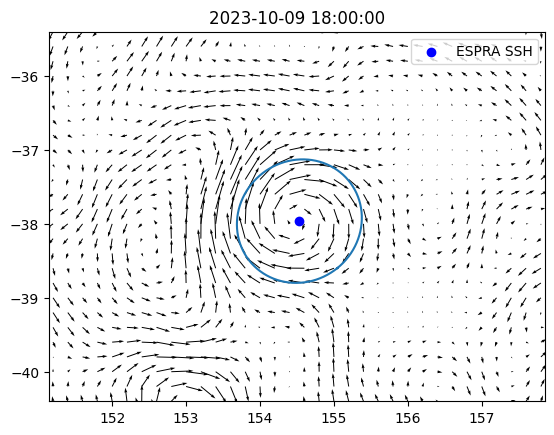

In [12]:
t = 0

time = tim_ssh[t]

ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
plt.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=.002, scale=15)

df = df_trace[df_trace['Time']==time]

plt.scatter(df['x0_SAT'], df['y0_SAT'], color='b', label='ESPRA SSH')
x_ellipse, y_ellipse = plot_ellipse(df['Q_SAT'].iloc[0], center=(df['x0_SAT'], df['y0_SAT']), scale=1)
plt.plot(x_ellipse, y_ellipse)

if not np.isnan(df.iloc[0]['x0_OBS']):
    plt.scatter(df['x0_OBS'], df['y0_OBS'], color='r', label='ESPRA OBS')
    x_ellipse, y_ellipse = plot_ellipse(df['Q_OBS'].iloc[0], center=(df['x0_OBS'], df['y0_OBS']), scale=1)
    plt.plot(x_ellipse, y_ellipse)

if time in list(dic_obs.keys()):
    xi, yi = dic_obs[time]['xi'], dic_obs[time]['yi']
    plt.scatter(xi, yi, marker='x', color='m', s=5)

plt.axis('equal')
plt.xlim(lon_min_CE-2, lon_max_CE+2)
plt.ylim(lat_min_CE-2, lat_max_CE+2)

plt.title(f'{time}')

plt.legend()

In [13]:
df_trace.to_pickle("Drifter_plot_data/df_trace.pkl")
with open("Drifter_plot_data/dic_obs.pkl", "wb") as f:
    pickle.dump(dic_obs, f)

# Utilize the drifters smaller time intervals

In [14]:
lon_min_CE, lon_max_CE = 154, 155
lat_min_CE, lat_max_CE = -38.4, -37.4

dic_obs = {}

x0, y0 = np.mean([lon_min_CE, lon_max_CE]), np.mean([lat_min_CE, lat_max_CE])
df_ssh_trace = pd.DataFrame(columns=['x0', 'y0', 'Q', 'w', 'Time'])
for t, time in enumerate(tim_ssh):
 
    if (x0 < lon_ssh.min()) or (x0 > lon_ssh.max()) or (y0 < lat_ssh.min()) or (y0 > lat_ssh.max()):
        break
    
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    if t == 0:
        mask = (lon_ssh >= lon_min_CE) & (lon_ssh <= lon_max_CE) & (lat_ssh >= lat_min_CE) & (lat_ssh <= lat_max_CE)
    else:
        mask = np.hypot(x0 - lon_ssh, y0 - lat_ssh) <= .2
    
    xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
    
    x0_old, y0_old = x0, y0
    x0, y0, Q, w = espra(xi, yi, ui, vi)

    if np.hypot(x0 - x0_old, y0 - y0_old) < 1:
        
        if not np.isnan(x0):
            dic_obs[time] = {'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi}
        
        df_ssh_trace.loc[len(df_ssh_trace)] = {'x0': x0, 'y0': y0, 'Q': Q, 'w': w, 'Time': time}
df_ssh_trace.head()

,x0,y0,Q,w,Time
0,154.532419,-37.962941,"[[-0.5416575626577694, 0.029117066031543553], ...",-2.191472,2023-10-09 18:00:00
1,154.466340,-37.930386,"[[-0.6980780329632007, 0.05264319772900968], [...",-2.868692,2023-10-10 18:00:00
2,154.448446,-37.909527,"[[-0.806986895158862, 0.09231684644359126], [0...",-3.113594,2023-10-11 18:00:00
3,154.455736,-37.891271,"[[-0.7593039067853671, 0.08077726314573079], [...",-2.972068,2023-10-12 18:00:00
4,154.464998,-37.877260,"[[-0.761974154137779, 0.055981465302784174], [...",-2.911793,2023-10-13 18:00:00


In [15]:
# Make it hourly
df_ssh_trace_hrly = df_ssh_trace.copy()
df_ssh_trace_hrly = df_ssh_trace_hrly.drop(columns=['Q', 'w'])
df_ssh_trace_hrly = df_ssh_trace_hrly.set_index('Time')
df_ssh_trace_hrly = df_ssh_trace_hrly.resample('h').interpolate()
df_ssh_trace_hrly = df_ssh_trace_hrly.reset_index()
df_ssh_trace_hrly

,Time,x0,y0
0,2023-10-09 18:00:00,154.532419,-37.962941
1,2023-10-09 19:00:00,154.529666,-37.961585
2,2023-10-09 20:00:00,154.526912,-37.960228
3,2023-10-09 21:00:00,154.524159,-37.958872
4,2023-10-09 22:00:00,154.521406,-37.957515
...,...,...,...
1352,2023-12-05 02:00:00,153.749923,-37.709694
1353,2023-12-05 03:00:00,153.749941,-37.704132
1354,2023-12-05 04:00:00,153.749958,-37.698571
1355,2023-12-05 05:00:00,153.749976,-37.693010


In [28]:
# Use the data around the Satellite trace  
dic_obs_hrly = {}
df_obs_trace_hrly = pd.DataFrame(columns=['x0', 'y0', 'Q', 'w', 'Time'])
for (x0, y0, time) in zip(df_ssh_trace_hrly['x0'], df_ssh_trace_hrly['y0'], df_ssh_trace_hrly['Time']):
    R = np.hypot(x0 - df_obs_data['Lon'], y0 - df_obs_data['Lat']) < 1
    t1 = time - pd.Timedelta(days=.5)
    t2 = time + pd.Timedelta(days=.5)
    local_obs_data = df_obs_data[(R) & (df_obs_data['Time'] >= t1) & (df_obs_data['Time'] <= t2)]
    
    if not local_obs_data.empty:
        xi, yi, ui, vi, ID = local_obs_data['Lon'], local_obs_data['Lat'], local_obs_data['u'], local_obs_data['v'], local_obs_data['ID']
        x0_obs, y0_obs, Q_obs, w_obs = espra(xi, yi, ui, vi)

        dic_obs_hrly[time] = pd.DataFrame({'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi, 'ID': ID})
        
        if np.hypot(x0 - x0_obs, y0 - y0_obs) <= 1:
            df_obs_trace_hrly.loc[len(df_obs_trace_hrly)] = {'x0': x0_obs, 'y0': y0_obs, 'Q': Q_obs, 'w': w_obs, 'Time': time}


In [29]:
local_obs_data

,ID,Lon,Lat,u,v,Time
23535,16.0,153.941422,-37.707260,-0.018092,-0.344699,2023-12-04 18:00:00
23540,13.0,153.211700,-37.550831,0.270336,0.323674,2023-12-04 18:00:00
23542,12.0,153.292099,-37.769276,-0.029246,0.200953,2023-12-04 18:00:00
23558,12.0,153.291504,-37.762199,-0.024409,0.234592,2023-12-04 19:00:00
23559,16.0,153.938950,-37.717815,-0.091701,-0.330333,2023-12-04 19:00:00
...,...,...,...,...,...,...
23973,12.0,153.267471,-37.646152,-0.047766,0.074293,2023-12-05 17:00:00
23974,16.0,153.765076,-37.980671,-0.219932,-0.359071,2023-12-05 17:00:00
23987,12.0,153.265366,-37.644176,-0.044789,0.058557,2023-12-05 18:00:00
23989,13.0,153.503296,-37.573387,0.099175,-0.376574,2023-12-05 18:00:00


In [30]:
df_obs_trace_hrly

,x0,y0,Q,w,Time
0,154.356835,-38.380162,"[[-1.9536374665571354, 0.0016807426697253616],...",-4.250644,2023-10-17 14:00:00
1,154.365183,-38.151085,"[[-2.0785267939769074, -0.01238748265138988], ...",-4.586075,2023-10-17 15:00:00
2,154.368145,-37.982849,"[[-2.1686789052250632, -0.02080158429145578], ...",-4.868323,2023-10-17 16:00:00
3,154.387813,-37.875921,"[[-2.737696730450018, -0.08987265045804667], [...",-6.105881,2023-10-17 17:00:00
4,154.413403,-37.836416,"[[-3.7952724097189, -0.3354761416332035], [-0....",-8.432736,2023-10-18 02:00:00
...,...,...,...,...,...
1107,153.467719,-37.712090,"[[-0.476822683328012, -0.0065074949066520026],...",-2.446425,2023-12-05 02:00:00
1108,153.456871,-37.708722,"[[-0.4721636366127621, -0.020242361425747236],...",-2.437052,2023-12-05 03:00:00
1109,153.444516,-37.706125,"[[-0.4675745914148906, -0.028401425067673996],...",-2.408529,2023-12-05 04:00:00
1110,153.432014,-37.704168,"[[-0.46322512370697694, -0.03309073020367078],...",-2.368614,2023-12-05 05:00:00


(-40.4, -35.4)

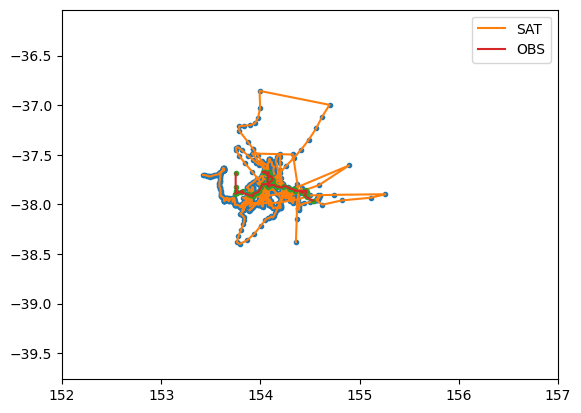

In [31]:
plt.plot(df_obs_trace_hrly['x0'], df_obs_trace_hrly['y0'], '.')
plt.plot(df_obs_trace_hrly['x0'], df_obs_trace_hrly['y0'], '-', label='SAT')

plt.plot(df_ssh_trace['x0'], df_ssh_trace['y0'], '.')
plt.plot(df_ssh_trace['x0'], df_ssh_trace['y0'], '-', label='OBS')

plt.legend()

plt.axis('equal')
plt.xlim(lon_min_CE-2, lon_max_CE+2)
plt.ylim(lat_min_CE-2, lat_max_CE+2)

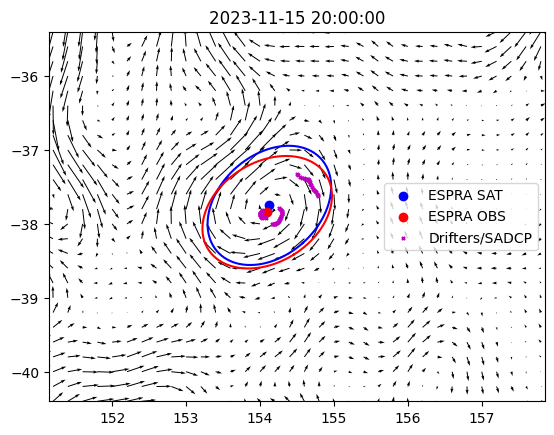

In [32]:
t = 645
timestamps = df_obs_trace_hrly['Time']
time = timestamps[t]

closest_row = df_ssh_trace[df_ssh_trace['Time'] <= time].iloc[-1]
if closest_row['Time'] in tim_ssh:
    t_closest = np.where(tim_ssh == closest_row['Time'])[0][0]
else:
    t_closest = np.abs(tim_ssh - closest_row['Time']).argmin()
ut, vt = u_ssh[:, :, t_closest], v_ssh[:, :, t_closest]
stride = 1
plt.quiver(lon_ssh[::stride, ::stride], lat_ssh[::stride, ::stride], 
      ut.T[::stride, ::stride], vt.T[::stride, ::stride], 
      width=0.002, scale=15)

day_ssh_data = df_ssh_trace.iloc[t_closest]
x0, y0, Q, w = day_ssh_data['x0'], day_ssh_data['y0'], day_ssh_data['Q'], day_ssh_data['w']
plt.scatter(x0, y0, label='ESPRA SAT', color='b')
x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=1)
plt.plot(x_ellipse, y_ellipse, 'b-')

hrly_obs_data = df_obs_trace_hrly[df_obs_trace_hrly['Time']==time]
if not hrly_obs_data.empty:
    x0_obs, y0_obs, Q_obs, w_obs = hrly_obs_data['x0'], hrly_obs_data['y0'], hrly_obs_data['Q'], hrly_obs_data['w']
    plt.scatter(x0_obs, y0_obs, label='ESPRA OBS', color='r')
    x_ellipse, y_ellipse = plot_ellipse(Q_obs.iloc[0], center=(x0_obs, y0_obs), scale=1)
    plt.plot(x_ellipse, y_ellipse, 'r-')

if time in dic_obs_hrly.keys():
    xi, yi = dic_obs_hrly[time]['xi'], dic_obs_hrly[time]['yi']
    plt.scatter(xi, yi, marker='x', color='m', s=5, label='Drifters/SADCP')

plt.axis('equal')
plt.xlim(lon_min_CE-2, lon_max_CE+2)
plt.ylim(lat_min_CE-2, lat_max_CE+2)

plt.title(f'{time}')
plt.legend()

In [33]:
ship_stamps = []
for stamp in list(dic_obs_hrly.keys()):
    if np.any(np.isnan(dic_obs_hrly[stamp]['ID'])):
        ship_stamps.append(stamp)

df_ship_indxs = pd.DataFrame(columns=['Time', 'obs indx'])
for time in tim_ssh:
    indx = np.where(time == np.array(ship_stamps))[0]
    if indx.size > 0:  
        indx = indx[0]
    
        df_ship_indxs.loc[len(df_ship_indxs)] = {'Time': time, 'obs indx': indx} 
df_ship_indxs

,Time,obs indx
0,2023-10-17 18:00:00,20
1,2023-10-18 18:00:00,44
2,2023-10-19 18:00:00,68
3,2023-10-20 18:00:00,92
4,2023-10-21 18:00:00,116


In [34]:
df = pd.DataFrame(columns=['Time', 'obs indx'])
timestamps = df_obs_trace_hrly['Time'].values 
for time in tim_ssh:
    indx = np.where(time == timestamps)[0]
    if indx.size > 0:  
        indx = indx[0]
        if indx >= df_ship_indxs.iloc[-1]['obs indx']:
            df.loc[len(df)] = {'Time': time, 'obs indx': indx}  
df_selected = df.iloc[np.linspace(0, len(df) - 5, 10, dtype=int)]
df_ship_selected = df_ship_indxs.iloc[np.linspace(0, len(df_ship_indxs) - 1, 5, dtype=int)]
ts = df_ship_selected['Time'].tolist() + df_selected['Time'].tolist()
df.head()

,Time,obs indx
0,2023-10-23 18:00:00,117
1,2023-10-24 18:00:00,141
2,2023-10-25 18:00:00,165
3,2023-10-26 18:00:00,189
4,2023-10-27 18:00:00,213


In [35]:
ts

[Timestamp('2023-10-17 18:00:00'),
 Timestamp('2023-10-18 18:00:00'),
 Timestamp('2023-10-19 18:00:00'),
 Timestamp('2023-10-20 18:00:00'),
 Timestamp('2023-10-21 18:00:00'),
 Timestamp('2023-10-23 18:00:00'),
 Timestamp('2023-10-27 18:00:00'),
 Timestamp('2023-10-31 18:00:00'),
 Timestamp('2023-11-04 18:00:00'),
 Timestamp('2023-11-08 18:00:00'),
 Timestamp('2023-11-14 06:00:00'),
 Timestamp('2023-11-18 06:00:00'),
 Timestamp('2023-11-22 06:00:00'),
 Timestamp('2023-11-26 06:00:00'),
 Timestamp('2023-12-01 06:00:00')]

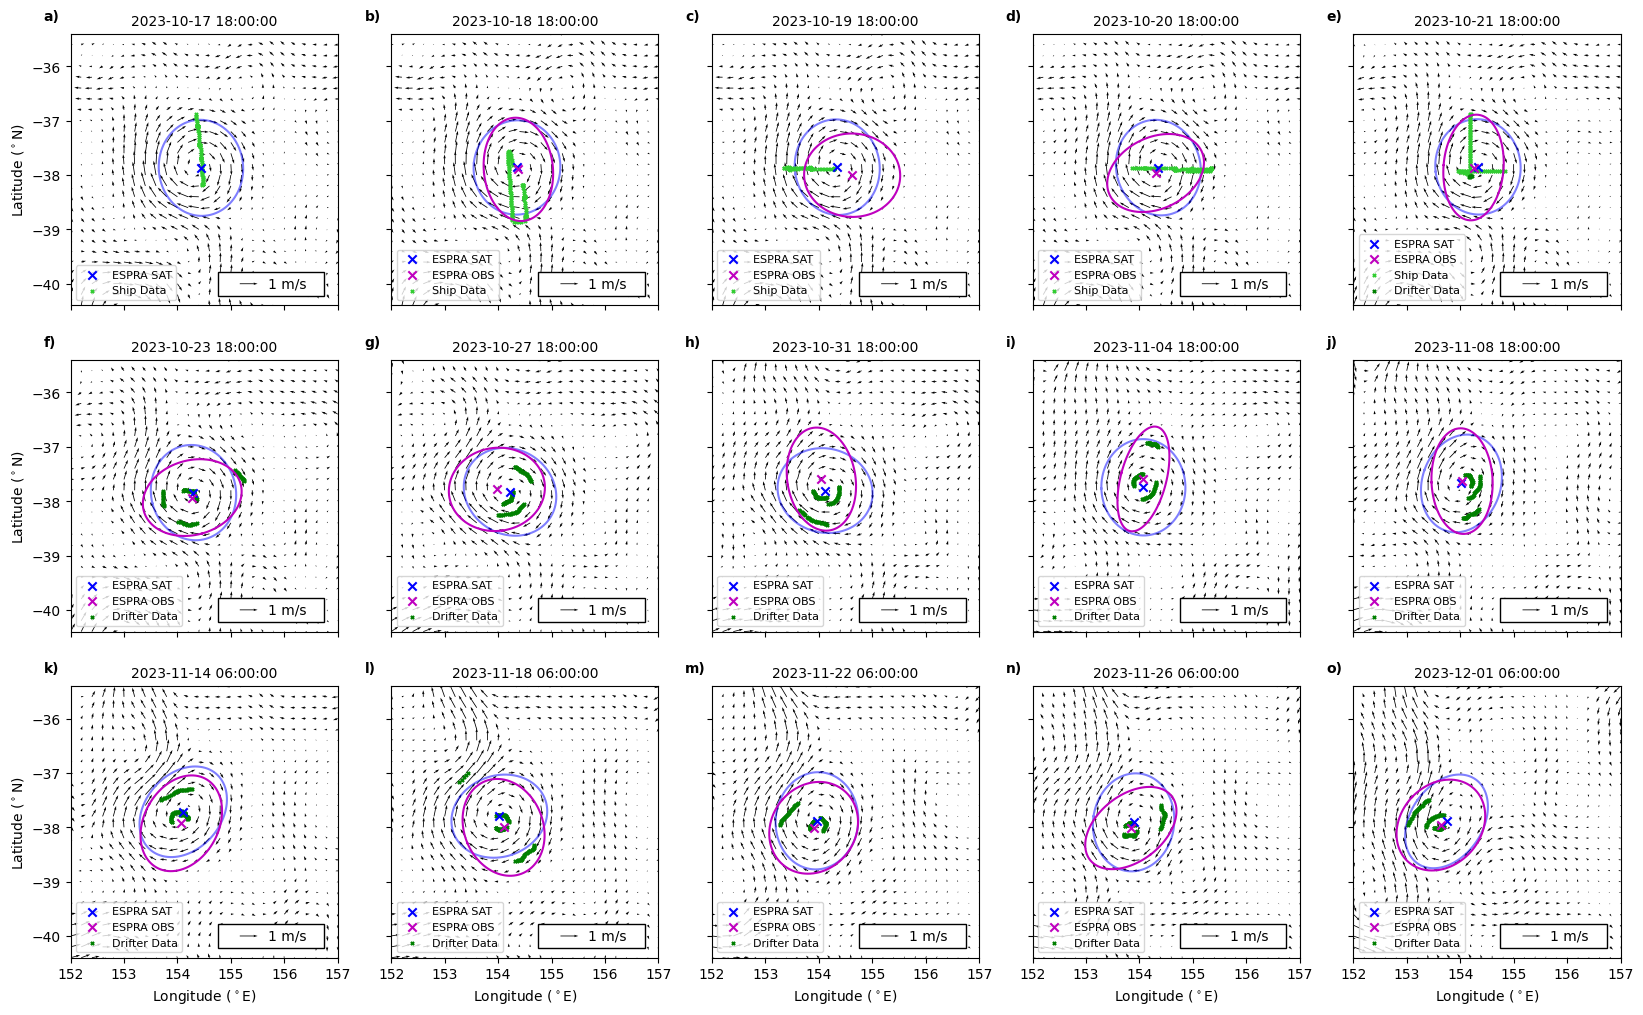

In [36]:
from matplotlib.patches import Rectangle

def int_to_excel(n):
    # Convert 0-indexed integer n to an Excel-style column label in lowercase
    n += 1  # Convert to 1-indexed
    result = ""
    while n:
        n, remainder = divmod(n - 1, 26)
        result = chr(97 + remainder) + result  # 97 is ASCII for 'a'
    return result

rows, cols = 3, 5

spwidth = 4

fig, axs = plt.subplots(rows, cols, figsize=(spwidth*cols,spwidth*rows), sharey=True, sharex=True)

for k, time in enumerate(ts):
    
    ax = axs[k // cols, k % cols]
    
    # timestamps = df_obs_trace_hrly['Time']
    # time = timestamps[t]
    
    closest_row = df_ssh_trace[df_ssh_trace['Time'] <= time].iloc[-1]
    if closest_row['Time'] in tim_ssh:
        t_closest = np.where(tim_ssh == closest_row['Time'])[0][0]
    else:
        t_closest = np.abs(tim_ssh - closest_row['Time']).argmin()
    ut, vt = u_ssh[:, :, t_closest], v_ssh[:, :, t_closest]
    stride = 1
    quiv = ax.quiver(lon_ssh[::stride, ::stride], lat_ssh[::stride, ::stride], 
          ut.T[::stride, ::stride], vt.T[::stride, ::stride], 
          width=0.003, scale=15)
    
    day_ssh_data = df_ssh_trace.iloc[t_closest]
    x0, y0, Q, w = day_ssh_data['x0'], day_ssh_data['y0'], day_ssh_data['Q'], day_ssh_data['w']
    ax.scatter(x0, y0, label='ESPRA SAT', color='b', marker='x', zorder=7, alpha=1)
    x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=1)
    ax.plot(x_ellipse, y_ellipse, 'b-', alpha=.5, zorder=5)
    
    hrly_obs_data = df_obs_trace_hrly[df_obs_trace_hrly['Time']==time]
    if not hrly_obs_data.empty:
        x0_obs, y0_obs, Q_obs, w_obs = hrly_obs_data['x0'], hrly_obs_data['y0'], hrly_obs_data['Q'].iloc[0], hrly_obs_data['w']
        ax.scatter(x0_obs, y0_obs, label='ESPRA OBS', color='m', marker='x', zorder=7)
        x_ellipse, y_ellipse = plot_ellipse(Q_obs, center=(x0_obs, y0_obs), scale=1)
        ax.plot(x_ellipse, y_ellipse, 'm-', zorder=7)

    if time in dic_obs_hrly:
        xi, yi, ID = dic_obs_hrly[time]['xi'], dic_obs_hrly[time]['yi'], dic_obs_hrly[time]['ID']
    
        xi_ship, yi_ship = xi[np.isnan(ID)], yi[np.isnan(ID)]
        if len(xi_ship) > 0:
            ax.scatter(xi_ship, yi_ship, marker='x', color='limegreen', s=5, label='Ship Data', zorder=6)
    
        xi_drift, yi_drift = xi[~np.isnan(ID)], yi[~np.isnan(ID)]
        if len(xi_drift) > 0:
            ax.scatter(xi_drift, yi_drift, marker='x', color='g', s=5, label='Drifter Data', zorder=6)

    
    # ax.axis('equal')
    ax.set_xlim(lon_min_CE-2, lon_max_CE+2)
    ax.set_ylim(lat_min_CE-2, lat_max_CE+2)
    
    ax.set_title(f'{time}', fontsize=10)
    ax.legend(loc='lower left', fontsize=8)

    if k % cols == 0:
        ax.set_ylabel(r'Latitude ($^\circ$N)')
    if k >= rows*cols - cols:
        ax.set_xlabel(r'Longitude ($^\circ$E)')

    ax.text(-0.1, 1.05, int_to_excel(k)+')', transform=ax.transAxes, fontsize=10, fontweight='bold')

    magnitude = 1
    x_pos, y_pos = 0.75, 0.08  
    box_width = 0.4 # Adjust width as needed
    box_height = 0.09  # Adjust height as needed
    rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                           box_width, box_height, transform=ax.transAxes,
                           facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    ax.quiverkey(quiv, X=x_pos-.05, Y=y_pos, U=magnitude,
                 label=f'{magnitude} m/s', labelpos='E')


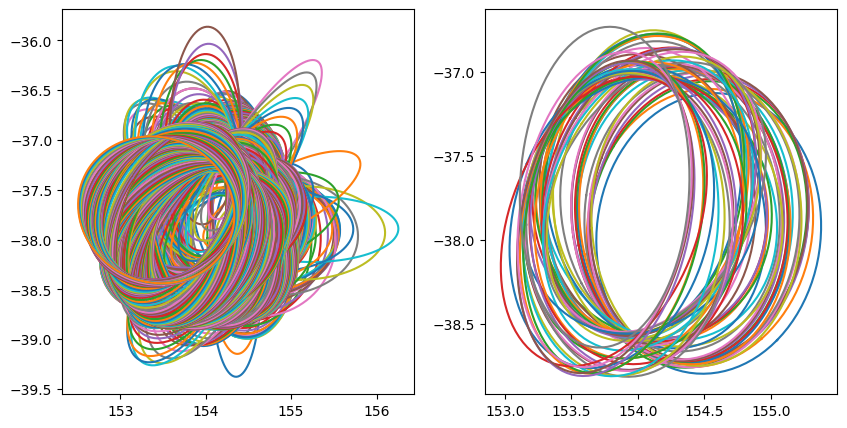

In [37]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for k in range(len(df_obs_trace_hrly)):
    Q = df_obs_trace_hrly.iloc[k]['Q']
    x0, y0 = df_obs_trace_hrly.iloc[k]['x0'], df_obs_trace_hrly.iloc[k]['y0']
    x_ellipse, y_ellipse = plot_ellipse(Q, (x0, y0))
    axs[0].plot(x_ellipse, y_ellipse)

for k in range(len(df_ssh_trace)):
    Q = df_ssh_trace.iloc[k]['Q']
    x0, y0 = df_ssh_trace.iloc[k]['x0'], df_ssh_trace.iloc[k]['y0']
    x_ellipse, y_ellipse = plot_ellipse(Q, (x0, y0))
    axs[1].plot(x_ellipse, y_ellipse)


,x0,y0,Q,w,Time
0,154.370258,-38.349670,"[[-2.1736884629742304, -0.01543989468173672], ...",-4.701965,2023-10-17 08:00:00
1,154.375582,-38.131792,"[[-2.302135888149136, -0.03006797876929076], [...",-5.046439,2023-10-17 09:00:00
2,154.368145,-37.982849,"[[-2.1686789052250632, -0.02080158429145578], ...",-4.868323,2023-10-17 10:00:00
3,154.387813,-37.875921,"[[-2.737696730450018, -0.08987265045804667], [...",-6.105881,2023-10-17 11:00:00
4,154.412961,-37.755210,"[[-4.689529088941388, -0.3467095197813928], [-...",-10.214612,2023-10-17 18:00:00
...,...,...,...,...,...
1153,153.468378,-37.708847,"[[-0.47332566296828416, 0.035340152424234994],...",-2.149225,2023-12-05 02:00:00
1154,153.461441,-37.708071,"[[-0.47132979585915197, 0.027645243271235822],...",-2.151439,2023-12-05 03:00:00
1155,153.453919,-37.704914,"[[-0.47070198677320724, 0.015926359325648932],...",-2.190662,2023-12-05 04:00:00
1156,153.446676,-37.701633,"[[-0.47035003656070323, 0.0014784975146677614]...",-2.230758,2023-12-05 05:00:00


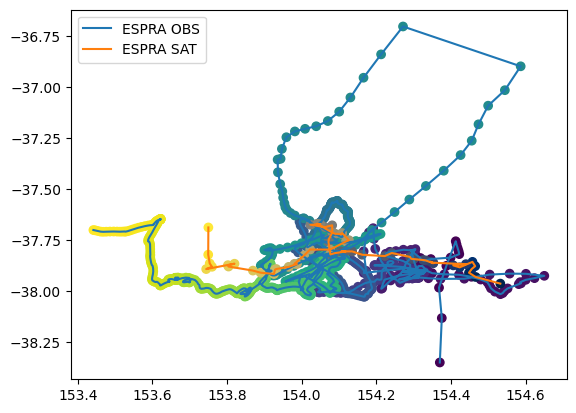

In [26]:
plt.plot(df_obs_trace_hrly['x0'], df_obs_trace_hrly['y0'], label='ESPRA OBS')
plt.scatter(df_obs_trace_hrly['x0'], df_obs_trace_hrly['y0'], c=df_obs_trace_hrly.index)
plt.plot(df_ssh_trace['x0'], df_ssh_trace['y0'], label='ESPRA SAT')
plt.scatter(df_ssh_trace['x0'], df_ssh_trace['y0'], c=df_ssh_trace.index, cmap='cividis')
plt.legend()
df_obs_trace_hrly

In [27]:
df_ssh_trace.to_pickle("Drifter_plot_data/df_ssh_trace.pkl")
df_obs_trace_hrly.to_pickle("Drifter_plot_data/df_obs_trace_hrly.pkl")
with open("Drifter_plot_data/dic_obs_hrly.pkl", "wb") as f:
    pickle.dump(dic_obs_hrly, f)